# Projet Big Data : Partie 1

## I] Collecte de données et étiquetage et annotation :

In [5]:
import os
def create_folder():
    if not os.path.exists('images'):
        os.makedirs('images')
    return

create_folder()

In [6]:
#Get our images on wikidata by a request
import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 100"""

#fonction qui va exécuter notre requête vers wikidata
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )

C:\Users\adrie\AppData\Local\Temp\ipykernel_236388\3871241469.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
# Put in a dataframe the data
dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(
    dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"}
)
dataframe

,ville,pays,image
0,Krasnoïarsk,Russie,http://commons.wikimedia.org/wiki/Special:File...
1,São Paulo,Brésil,http://commons.wikimedia.org/wiki/Special:File...
2,Boston,États-Unis,http://commons.wikimedia.org/wiki/Special:File...
3,Le Caire,Égypte,http://commons.wikimedia.org/wiki/Special:File...
4,Szczecin,Pologne,http://commons.wikimedia.org/wiki/Special:File...
...,...,...,...
95,Padoue,Italie,http://commons.wikimedia.org/wiki/Special:File...
96,Buenos Aires,Argentine,http://commons.wikimedia.org/wiki/Special:File...
97,Lyon,France,http://commons.wikimedia.org/wiki/Special:File...
98,Le Mans,France,http://commons.wikimedia.org/wiki/Special:File...


In [8]:
import requests
import shutil
import os
from urllib.parse import urlparse, unquote


def download_image(url):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    
    if request.status_code == 200:
        # Créez un dossier nommé "images" s'il n'existe pas déjà
        if not os.path.exists("images"):
            os.makedirs("images")
        
        # Extract the filename from the URL and unquote it to remove %20 for spaces
        filename = os.path.join("images",os.path.basename(urlparse(url).path))
        filename = unquote(filename)
        # Enregistrez l'image dans le dossier "images"
        with open(filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
        
        return f"Image enregistrée avec succès dans le dossier 'images' : {filename}"
    else:
        return f"Échec de la requête avec le code d'état : {request.status_code}"


In [9]:
# We call the download fonction
dataframe.image.apply(download_image)

0     Image enregistrée avec succès dans le dossier ...
1     Image enregistrée avec succès dans le dossier ...
2     Image enregistrée avec succès dans le dossier ...
3     Image enregistrée avec succès dans le dossier ...
4     Image enregistrée avec succès dans le dossier ...
                            ...                        
95    Image enregistrée avec succès dans le dossier ...
96    Image enregistrée avec succès dans le dossier ...
97    Image enregistrée avec succès dans le dossier ...
98    Image enregistrée avec succès dans le dossier ...
99    Image enregistrée avec succès dans le dossier ...
Name: image, Length: 100, dtype: object

In [15]:
import os
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import json
import numpy as np
from sklearn.cluster import KMeans
from skimage import io, color


def extract_image_metadata(image_path):
    image_metadata = {}
    try:
        with Image.open(image_path) as img:
            image_metadata['size'] = img.size
            image_metadata['format'] = img.format
            image_metadata['mode'] = img.mode
            exif_data = img._getexif()
            if exif_data:
                # Extraire des métadonnées EXIF spécifiques si elles existent
                image_metadata['orientation'] = exif_data.get(274)
                image_metadata['date_created'] = exif_data.get(306)
                image_metadata['camera_model'] = exif_data.get(272)
            
            # Extraire les couleurs prédominantes
            img = color.rgb2lab(io.imread(image_path))
            reshaped = img.reshape(-1, 3)
            kmeans = KMeans(n_clusters=3)
            kmeans.fit(reshaped)
            lab_values = kmeans.cluster_centers.tolist()

            # Convertir les valeurs LAB en RGB
            rgb_values = color.lab2rgb(lab_values)

            # Mettre à l'échelle les valeurs RGB entre 0 et 255
            rgb_values *= 255
            rgb_values = np.round(rgb_values).astype(np.uint8).tolist()

            image_metadata['dominant_colors'] = rgb_values
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
    return image_metadata

def save_metadata_to_json(metadata, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(metadata, json_file, indent=4)

# Chemin vers le dossier contenant les images
images_folder = "images"

# Liste pour stocker les métadonnées de chaque image
images_metadata = []

# Parcourir toutes les images dans le dossier
for filename in os.listdir(images_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filtrer les types de fichiers d'image pris en charge
        image_path = os.path.join(images_folder, filename)
        metadata = extract_image_metadata(image_path)
        if metadata:
            # Ajouter les métadonnées extraites à la liste
            images_metadata.append(metadata)
            # Enregistrer les métadonnées dans un fichier JSON avec le même nom que l'image
            output_file = os.path.splitext(image_path)[0] + '.json'
            save_metadata_to_json(metadata, output_file)

# Enregistrer toutes les métadonnées dans un seul fichier JSON
all_metadata_file = "all_images_metadata.json"
save_metadata_to_json(images_metadata, all_metadata_file)

Error processing image images\00 0781 Canal in Delft (NL).jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\00 3178 Sydney, Australia.jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\00 6191 Maastricht - Niederlande.jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\00 sea towers (April 2018).jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\01. Panorama de Lyon pris depuis le toit de la Basilique de Fourvière.jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\138 - Place de la Bourse et le miroir d'eau - Bordeaux.jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\15-Nouakchott-eH-R0058185.jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processing image images\19-03-03-Maribor-RalfR-DJI 0444.jpg: 'KMeans' object has no attribute 'cluster_centers'
Error processin

## II] Récupération des métadonnées

In [7]:
import os
#get all images
def get_all_images(source="images"):
    images = []
    for filename in os.listdir(source):
        if filename.endswith(".jpg"):
            images.append(filename)
    return images

In [8]:
# Récupération des couleurs prédominantes 
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import numpy
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def get_color(image_path):
    imgfile = Image.open(image_path)

    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    n_clusters = 4
    clusters = KMeans(n_clusters, n_init=2)
    clusters.fit(numarray)
    npbins = numpy.arange(0, n_clusters + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)

    # Zip des étiquettes et des hauteurs de barres, puis tri par étiquettes
    sorted_data = sorted(zip(labels, histogram[0]), key=lambda x: x[0])

    # Récupération des étiquettes triées et des hauteurs triées
    sorted_labels, sorted_heights = zip(*sorted_data)

    # Création des histogrammes triés
    barlist = plt.bar(sorted_labels, sorted_heights)
    colors =[]
    # Coloration des histogrammes avec les couleurs des clusters
    for i in range(n_clusters):
        colors.append(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )
        barlist[i].set_color(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )
        )
    #print(colors)
    return colors

{'00 0781 Canal in Delft (NL).jpg': ['#32331f', '#a6caf4', '#565d61', '#9c9784']}
{'00 0781 Canal in Delft (NL).jpg': ['#32331f', '#a6caf4', '#565d61', '#9c9784'], '00 3178 Sydney, Australia.jpg': ['#a7a4a9', '#2f3032', '#667aa1', '#806d68']}
{'00 0781 Canal in Delft (NL).jpg': ['#32331f', '#a6caf4', '#565d61', '#9c9784'], '00 3178 Sydney, Australia.jpg': ['#a7a4a9', '#2f3032', '#667aa1', '#806d68'], '00 6191 Maastricht - Niederlande.jpg': ['#5c4d3f', '#867a69', '#302922', '#a3a5a5']}
{'00 0781 Canal in Delft (NL).jpg': ['#32331f', '#a6caf4', '#565d61', '#9c9784'], '00 3178 Sydney, Australia.jpg': ['#a7a4a9', '#2f3032', '#667aa1', '#806d68'], '00 6191 Maastricht - Niederlande.jpg': ['#5c4d3f', '#867a69', '#302922', '#a3a5a5'], '00 sea towers (April 2018).jpg': ['#b6babe', '#5b6569', '#7898b7', '#282d31']}
{'00 0781 Canal in Delft (NL).jpg': ['#32331f', '#a6caf4', '#565d61', '#9c9784'], '00 3178 Sydney, Australia.jpg': ['#a7a4a9', '#2f3032', '#667aa1', '#806d68'], '00 6191 Maastricht - 

KeyboardInterrupt: 

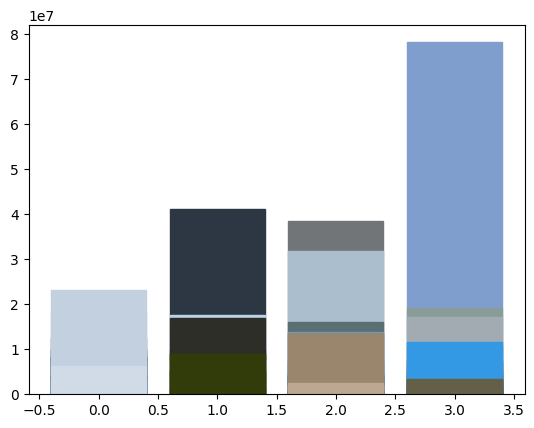

In [9]:
# Get color for all my images files
import json

def metadata_color_images():
    images = get_all_images()
    color_metadata = {}
    for image in images:
        try:
            color_metadata[image] = get_color(f"images/{image}")
            print(color_metadata)
        except Exception as e:
            continue
    with open("color_data.json","w") as file:
        json.dump(color_metadata, file, default=str)
    return

metadata_color_images()

# III] Mise en place des tags sur les images #